In [159]:
!pip install --upgrade tensorflow keras tf2onnx

  Using cached tf2onnx-1.16.1-py3-none-any.whl (455 kB)
  Using cached tf2onnx-1.16.0-py3-none-any.whl (455 kB)
  Using cached tf2onnx-1.15.1-py3-none-any.whl (454 kB)
  Using cached tf2onnx-1.15.0-py3-none-any.whl (454 kB)
  Using cached tf2onnx-1.14.0-py3-none-any.whl (451 kB)
  Using cached tf2onnx-1.13.0-py3-none-any.whl (442 kB)
  Using cached tf2onnx-1.12.1-py3-none-any.whl (442 kB)
  Using cached tf2onnx-1.12.0-py3-none-any.whl (442 kB)
  Using cached tf2onnx-1.11.1-py3-none-any.whl (440 kB)
  Using cached tf2onnx-1.10.1-py3-none-any.whl (440 kB)
  Using cached tf2onnx-1.9.3-py3-none-any.whl (435 kB)
  Using cached tf2onnx-1.9.2-py3-none-any.whl (430 kB)
  Using cached tf2onnx-1.9.1-py3-none-any.whl (398 kB)
  Using cached tf2onnx-1.8.5-py3-none-any.whl (370 kB)


In [160]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tf2onnx
import onnx

In [ ]:
#path to file generated by other script will take more than one data set
DATA_FILES = [r"./data/synthetic_data_independent_failures_5.csv", "./data/synthetic_data_independent_failures_4.csv"]

SEQUENCE_LENGTH = 24 * 2
STEP_SIZE = 24
FORECAST_HORIZON = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [162]:
# Data processing 
def load_and_combine_data(file_paths):
    """
    Loads multiple CSV files, finds the union of all sensor features, 
    reindexes dataframes to match the full feature set (filling missing sensors with 0.0), 
    and concatenates them into a single DataFrame.
    """
    all_data = []
    all_sensor_features = set()
    
    # Load data and collect all unique sensor feature names
    non_sensor_cols = ['machine_id', "timestamp",'failure_mode', 'is_precursor_period', 'is_final_failure']
    
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            
            # Identify potential sensor features in the current file
            current_sensor_features = [col for col in df.columns if col not in non_sensor_cols]
            print(current_sensor_features)
            all_sensor_features.update(current_sensor_features)
            
            all_data.append(df)
            print(f"Loaded {file_path} with {len(current_sensor_features)} sensor features.")
        except FileNotFoundError:
            print(f"Warning: File '{file_path}' not found. Skipping.")
    
    if not all_data:
        raise FileNotFoundError("No valid data files were loaded.")

    
    sensor_feature_list = sorted(list(all_sensor_features))
    final_combined_df = pd.DataFrame()
    full_column_list = non_sensor_cols + sensor_feature_list
    
    for df in all_data:
        
        df_reindexed = df.reindex(columns=full_column_list, fill_value=0.0)
        
        final_combined_df = pd.concat([final_combined_df, df_reindexed], ignore_index=True)

    print(f"\nSuccessfully combined {len(all_data)} files.")
    print(f"Total rows in combined data: {len(final_combined_df)}")
    print(f"Total unique sensor features used: {len(sensor_feature_list)}")
    
    return final_combined_df, sensor_feature_list

In [163]:
try:
    data, sensor_features = load_and_combine_data(DATA_FILES)
except FileNotFoundError as e:
    print(f"Fatal Error: {e}")

['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_5.csv with 2 sensor features.
['T_internal_sensor', 'V_sensor']
Loaded ./data/synthetic_data_independent_failures_4.csv with 2 sensor features.

Successfully combined 2 files.
Total rows in combined data: 236520
Total unique sensor features used: 2


In [164]:
def create_sequences(data, seq_length, forecast_horizon, step_size):
    sequences = []
    target = []
    for i in range(0, len(data) - seq_length - forecast_horizon + 1, step_size):
        sequences.append(data[i:i+seq_length])
        target.append(data[i+seq_length: i+seq_length+forecast_horizon])
    return np.array(sequences), np.array(target)

In [165]:
def prepare_data(df, sensor_features):
    """Loads, cleans, labels, and scales the data. Returns sequences and the fitted scaler."""
    sensor_data = df[sensor_features].values
   
    # 2. Standardization
    scaler = StandardScaler()
    sensor_data_scaled = scaler.fit_transform(sensor_data)
    
    # 3. Create Sequences
    X_seq, Y_seq = create_sequences(sensor_data_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON, STEP_SIZE)
    
    print(f"\n--- Data Preparation Complete ---")
    print(f"Total time points in raw data: {len(df)}")
    print(f"Total sequences created: {len(X_seq)}")
    print(f"Sequence shape (num_samples, time steps, features): {X_seq.shape}")
    
    # Return the fitted scaler so we can inverse-transform predictions later
    return X_seq, Y_seq, scaler

In [166]:
X_seq, Y_seq, scaler = prepare_data(data, sensor_features)

# Split data into training, validation, and testing sets for 3D arrays
# First split: 80% train+val, 20% test
indices = np.arange(X_seq.shape[0])
train_val_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=False)

# Second split: 75% train, 25% val (of the train+val set = 60% train, 20% val overall)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.25, random_state=42, shuffle=False)

X_train, X_val, X_test = X_seq[train_indices], X_seq[val_indices], X_seq[test_indices]
Y_train, Y_val, Y_test = Y_seq[train_indices], Y_seq[val_indices], Y_seq[test_indices]



--- Data Preparation Complete ---
Total time points in raw data: 236520
Total sequences created: 9854
Sequence shape (num_samples, time steps, features): (9854, 24, 2)


In [167]:
# TensorFlow/Keras doesn't need a custom Dataset class
# Data will be prepared directly as numpy arrays

In [168]:
X_train.shape, Y_train.shape

((5912, 24, 2), (5912, 1, 2))

In [169]:
# Prepare data for each sensor feature
# TensorFlow expects data in shape (samples, timesteps, features)
print(f"\nPreparing data for {X_train.shape[2]} sensor features...")
print(f"Data shapes: X_train={X_train.shape}, Y_train={Y_train.shape}")


Preparing data for 2 sensor features...
Data shapes: X_train=(5912, 24, 2), Y_train=(5912, 1, 2)


In [170]:
def create_cnn_model(seq_length, forecast_horizon):
    """
    Simple 1D CNN for time-series regression built with TensorFlow/Keras.
    Architecture: Conv1D -> MaxPool -> Dense -> Output
    """
    model = models.Sequential([
        layers.Input(shape=(seq_length, 1)),
        layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='valid'),
        layers.Dropout(0.25),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(forecast_horizon)
    ])
    
    return model

In [171]:
# --- 3. TRAINING AND EVALUATION ---
def prepare_feature_data(X, Y, feature_idx):
    """Extract data for a specific feature index."""
    X_feature = X[:, :, feature_idx:feature_idx+1]
    Y_feature = Y[:, :, feature_idx].squeeze()
    return X_feature, Y_feature


In [172]:
def evaluate_model(model, X_test, Y_test):
    """TensorFlow/Keras evaluation."""
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    y_true = Y_test
    
    return y_true, y_pred

def calculate_msre(y_pred, y_true):
    avg_error_per_column = np.mean(np.abs(y_true - y_pred), axis=0)
    print(f"Average error per column: {avg_error_per_column}")
    mse = np.mean((y_true - y_pred) ** 2)
    print(f"Total MSE: {mse}")
    return np.sqrt(mse)

In [173]:
select_model = 0

In [174]:
# Build the TensorFlow/Keras CNN model
model = create_cnn_model(X_train.shape[1], FORECAST_HORIZON)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()
print("\nModel Architecture:")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 20, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50)             │        32,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,485 (126.89 KB)

 Trainable params: 32,485 (126.89 KB)

 Non-trainable params: 0 (0.00 B)


Model Architecture:


In [175]:
# Prepare data for the selected feature
X_train_feature, Y_train_feature = prepare_feature_data(X_train, Y_train, select_model)
X_val_feature, Y_val_feature = prepare_feature_data(X_val, Y_val, select_model)
X_test_feature, Y_test_feature = prepare_feature_data(X_test, Y_test, select_model)

print(f"Training feature {select_model}: {sensor_features[select_model]}")
print(f"X_train_feature shape: {X_train_feature.shape}")
print(f"Y_train_feature shape: {Y_train_feature.shape}")

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    X_train_feature,
    Y_train_feature,
    validation_data=(X_val_feature, Y_val_feature),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Training feature 0: T_internal_sensor
X_train_feature shape: (5912, 24, 1)
Y_train_feature shape: (5912,)
Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0391 - mae: 0.1507 - val_loss: 0.0371 - val_mae: 0.1498 - learning_rate: 0.0010
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0320 - mae: 0.1384 - val_loss: 0.0341 - val_mae: 0.1425 - learning_rate: 0.0010
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0304 - mae: 0.1362 - val_loss: 0.0315 - val_mae: 0.1350 - learning_rate: 0.0010
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0296 - mae: 0.1351 - val_loss: 0.0322 - val_mae: 0.1383 - learning_rate: 0.0010
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0295 - mae: 0.1343 - val_loss: 0.0326 - val_mae: 0.1391 - learning_rate: 0.0010
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0288 - mae: 0.1332 - val_loss: 0.0283 - val_mae: 0.1284 - learning_rate: 0.0010
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━

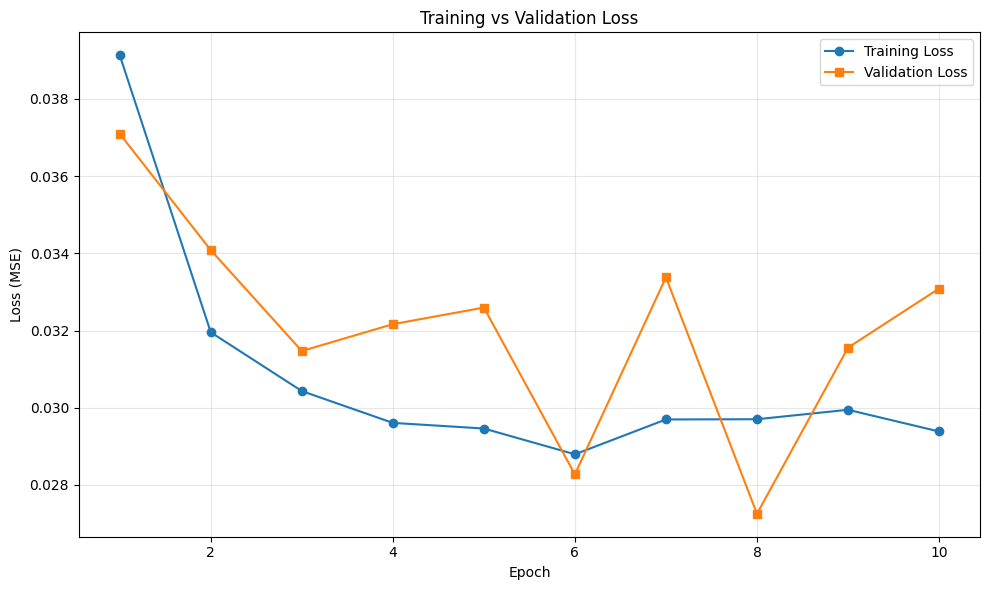


Final Training Loss: 0.0294
Final Validation Loss: 0.0331
Difference (Val - Train): 0.0037
Ratio (Val / Train): 1.13


In [176]:
# Plot training and validation loss
import matplotlib.pyplot as plt

train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
loss_diff = final_val_loss - final_train_loss
loss_ratio = final_val_loss / final_train_loss

print(f"\nFinal Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

print(f"Difference (Val - Train): {loss_diff:.4f}")
print(f"Ratio (Val / Train): {loss_ratio:.2f}")

In [177]:
# Evaluate the model
print("\n--- Evaluating Model Performance ---")
y_true, y_pred = evaluate_model(model, X_test_feature, Y_test_feature)

# Regression metrics
mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_true.flatten(), y_pred.flatten())

print("\nRegression Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


--- Evaluating Model Performance ---

Regression Metrics:
Mean Squared Error (MSE): 0.0262
Root Mean Squared Error (RMSE): 0.1618
Mean Absolute Error (MAE): 0.1279
R² Score: 0.8817


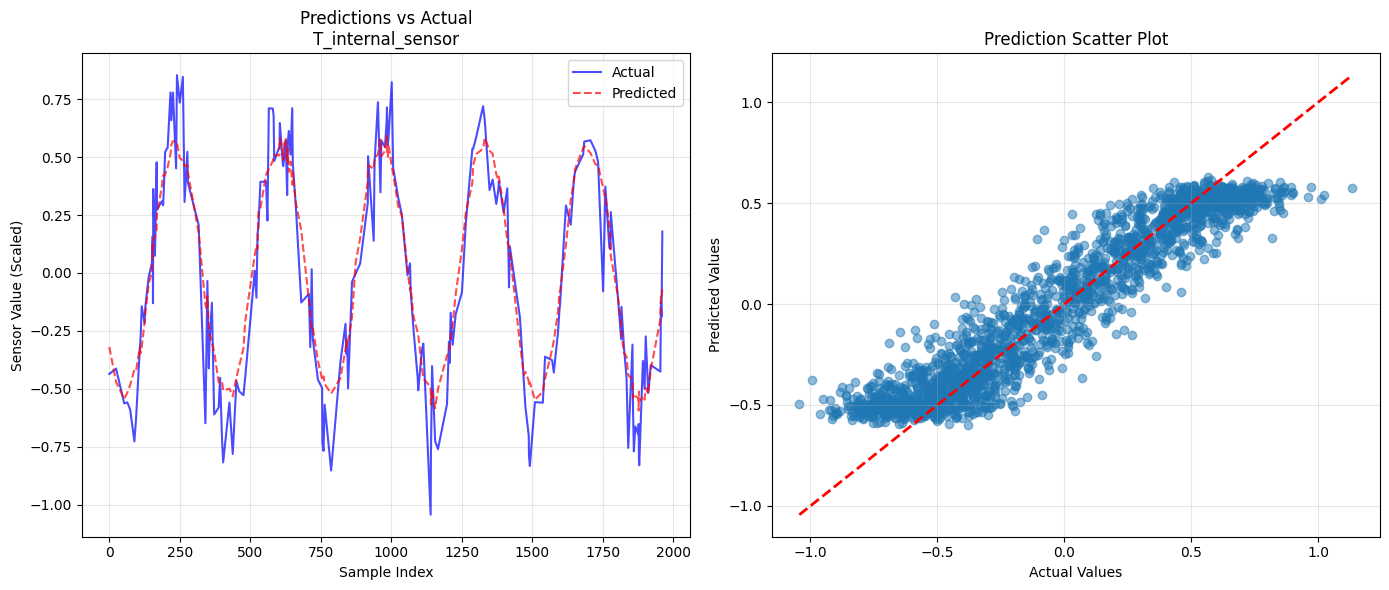

In [178]:
y_true_flat = np.array(y_true).reshape(-1)
y_pred_flat = np.array(y_pred).reshape(-1)

plt.figure(figsize=(14, 6))

# Sample a subset for visualization if too many points
num_samples = min(200, len(y_true_flat))
if num_samples == 0:
    print("No test samples available to plot.")
else:
    indices = np.random.choice(len(y_true_flat), num_samples, replace=False)
    indices = np.sort(indices)

    plt.subplot(1, 2, 1)
    plt.plot(indices, y_true_flat[indices], 'b-', label='Actual', alpha=0.7)
    plt.plot(indices, y_pred_flat[indices], 'r--', label='Predicted', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value (Scaled)')
    plt.title(f'Predictions vs Actual\n{sensor_features[select_model]}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(y_true_flat, y_pred_flat, alpha=0.5)
    mn = min(y_true_flat.min(), y_pred_flat.min())
    mx = max(y_true_flat.max(), y_pred_flat.max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction Scatter Plot')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [179]:
# Save the model as ONNX
import tf2onnx
model.output_names=['output']

onnx_path = "./model/temperature.onnx"
onnx_model, _ = tf2onnx.convert.from_keras(
    model, 
    input_signature=(tf.TensorSpec((None, SEQUENCE_LENGTH, 1), tf.float32),)
)
with open(onnx_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

# Test the size of the ONNX model
import os
onnx_size = os.path.getsize(onnx_path) / (1024 * 1024)  # Size in MB
print(f"ONNX model size: {onnx_size:.2f} MB")

I0000 00:00:1763070778.593994    2016 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1763070778.594710    2016 single_machine.cc:376] Starting new session
I0000 00:00:1763070778.693645    2016 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1763070778.694075    2016 single_machine.cc:376] Starting new session
rewriter <function rewrite_constant_fold at 0x7bd8b5f34700>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


ONNX model size: 0.13 MB
